# Be safe - who is in the biggest need for PPE?

In the time of Coronavirus outbreak, as a fresh graduate of Data Science, I would like to utilize my skills and help the World, as the World someday may help me. The goal of this notebook is to find by observation places and people that are in the biggest need of the Personal Protective Equipment (PPE) in the COVID-19 time.

For the analysis, I was using the following datasets:

* ECDC/current-data-on-the-geographic-distribution-of-covid-19-cases-worldwide.csv - dataset presenting the daily number of cases/deaths around all of the countries in the world.
* johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-by-country.csv - another dataset showing the number of cases for countries, but showing only the most actual value (dataset is updating on the Kaggle).
* HDE_update/inform-covid-indicators.csv - contains country data with different information like density, percentage of people in urban areas, sanitation services etc.
* HDE/total-covid-19-tests-performed-by-country.csv - data about the number of tests performed by countries.
* esri_covid-19/definitive-healthcare-usa-hospital-beds.csv - various data about USA hospitals (number of staff, types of beds etc.)
* covid_tracking_project/covid-statistics-by-us-states-totals.csv - data about sick people in the US with information about hospitalized people.

Now first let's import all of the python packages that may be useful during the analysis

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark')

In [39]:
ecdc_infections = pd.read_csv('kaggle/input/uncover/UNCOVER/ECDC/current-data-on-the-geographic-distribution-of-covid-19-cases-worldwide.csv')
ecdc_infections.head()
ecdc_infections[ecdc_infections['countriesandterritories']=='Uzbekistan']

,daterep,day,month,year,cases,deaths,countriesandterritories,geoid,countryterritorycode,popdata2018
8735,2020-04-05,5,4,2020,39,0,Uzbekistan,UZ,UZB,32955400.0
8736,2020-04-04,4,4,2020,37,0,Uzbekistan,UZ,UZB,32955400.0
8737,2020-04-03,3,4,2020,3,0,Uzbekistan,UZ,UZB,32955400.0
8738,2020-04-02,2,4,2020,14,0,Uzbekistan,UZ,UZB,32955400.0
8739,2020-04-01,1,4,2020,24,0,Uzbekistan,UZ,UZB,32955400.0
8740,2020-03-31,31,3,2020,4,1,Uzbekistan,UZ,UZB,32955400.0
8741,2020-03-30,30,3,2020,12,0,Uzbekistan,UZ,UZB,32955400.0
8742,2020-03-29,29,3,2020,29,1,Uzbekistan,UZ,UZB,32955400.0
8743,2020-03-28,28,3,2020,21,0,Uzbekistan,UZ,UZB,32955400.0
8744,2020-03-27,27,3,2020,18,0,Uzbekistan,UZ,UZB,32955400.0


In [6]:
infections = pd.read_csv('kaggle/input/uncover/UNCOVER/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-by-country.csv')
infections.head()

,country_region,last_update,lat,long,confirmed,deaths,recovered,active
0,Australia,2020-04-05 18:30:54,-25.0000,133.0000,5687,35,757,4895
1,Austria,2020-04-05 18:24:16,47.5162,14.5501,12051,204,2998,8849
2,Canada,2020-04-05 18:30:39,60.0010,-95.0010,14426,259,3000,0
3,China,2020-04-05 09:23:04,30.5928,114.3055,82602,3333,77207,2062
4,Denmark,2020-04-05 18:24:16,56.0000,10.0000,4561,179,1429,2953


In [7]:
country_information = pd.read_csv('kaggle/input/uncover/UNCOVER/HDE_update/inform-covid-indicators.csv')
country_information["population_living_in_urban_areas"] = country_information["population_living_in_urban_areas"].replace('No data', None)
country_information["population_living_in_urban_areas"] = country_information["population_living_in_urban_areas"].astype('float64')
country_information.head()

,country,iso3,inform_risk,inform_p2p_hazard_and_exposure_dimension,population_density,population_living_in_urban_areas,proportion_of_population_with_basic_handwashing_facilities_on_premises,people_using_at_least_basic_sanitation_services,inform_vulnerability,inform_health_conditions,inform_epidemic_vulnerability,mortality_rate_under_5,prevalence_of_undernourishment,inform_lack_of_coping_capacity,inform_access_to_healthcare,inform_epidemic_lack_of_coping_capacity,physicians_density,current_health_expenditure_per_capita,maternal_mortality_ratio
0,Afghanistan,AFG,8.0,6.2,56.94,25.495,37.75,43.41761,8.2,2.1,4.5,67.900001525878906,29.8,7.2,7.6,6.7,2.84,162.78,396.00
1,Albania,ALB,3.0,3.6,104.61,60.319,No data,97.71837,1.6,0.2,3.7,8.8000001907348597,6.2,4.2,3.7,4.9,12.00,759.67,29.00
2,Algeria,DZA,4.0,4.3,17.73,72.629,83.74,87.58657,2.9,0.4,5.9,24,3.9,4.4,3.8,3.6,18.30,998.15,140.00
3,Angola,AGO,5.2,6.7,24.71,65.514,26.66,49.87698,5.0,5,5.8,81.099998474121094,25.0,7.1,8.1,5.4,2.15,185.82,477.00
4,Antigua and Barbuda,ATG,2.3,2.8,218.83,24.599,No data,87.50428,1.7,0,3.5,7.4000000953674299,18.1,3.8,4.3,3.2,27.65,976.39,No data


In [8]:
tests = pd.read_csv('kaggle/input/uncover/UNCOVER/HDE_update/HDE/total-covid-19-tests-performed-by-country.csv')
tests.head()

,entity,code,year,total_covid_19_tests
0,Armenia,ARM,57,813
1,Australia,AUS,59,113615
2,Australia - Australian Capital Territory,NaN,59,2062
3,Australia - New South Wales,NaN,58,39089
4,Australia - Queensland,NaN,58,27000


## Which country has the highest infection rate in comparison to the population?

First let's see how the infections was changing for the top 15 countries with the highest rate of the infections in the ECDC dataset.

In [111]:
d = ecdc_infections.copy()
d = d.drop(["day", "month", "year", "geoid", "countryterritorycode", "popdata2018"], axis=1)
d = d.groupby(["countriesandterritories","daterep"]).sum().unstack(level=0)
d[d.index=="2020-04-05"].xs("cases", axis=1).sort_values(by="2020-04-05", axis=1, ascending=False).iloc[:, 0:10].columns

Index(['United_States_of_America', 'Germany', 'Spain', 'Iran', 'Italy',
       'France', 'United_Kingdom', 'Turkey', 'Belgium', 'Canada'],
      dtype='object', name='countriesandterritories')

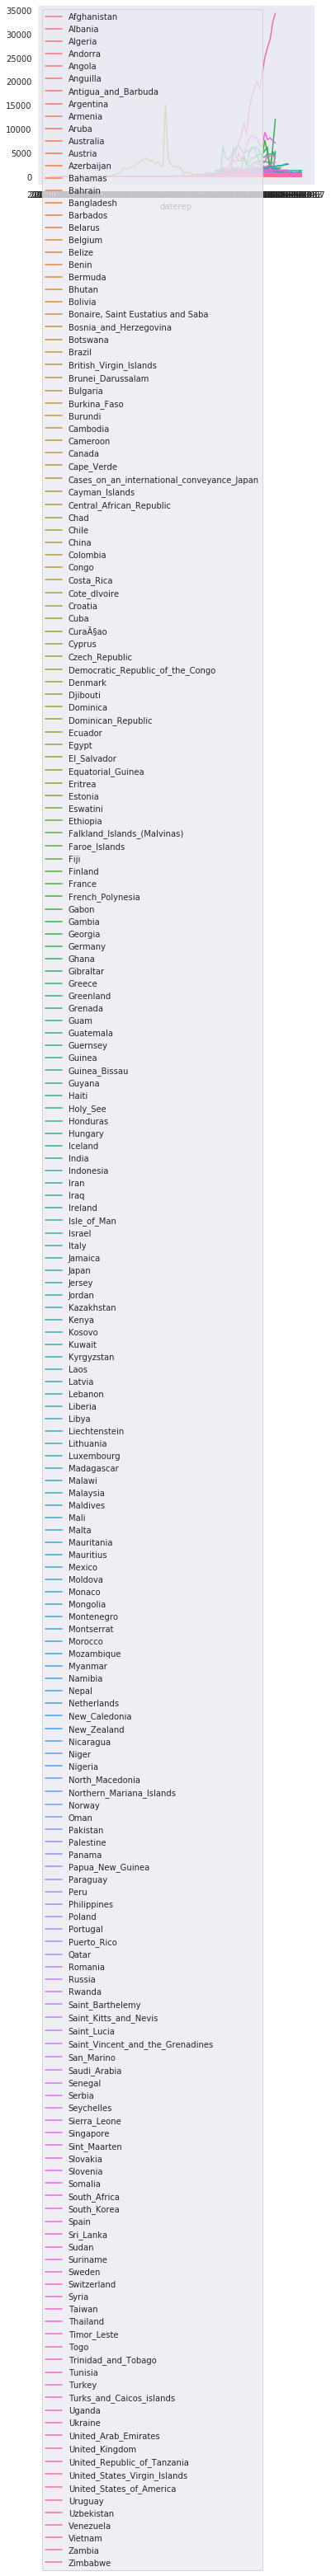

In [98]:
sns.lineplot(data=d.xs("cases", axis=1), dashes=False)

Let's accumulate the active cases for all countries, then let's calculate the percentage of sick people with the density of this country. The data will be for the 5th of April, as I didn't find anything more accurate from UNCOVER dataset.

In [9]:
def getDensity(countryName, country_info = country_information):
    code = country_info[country_info['country'] == countryName]['population_density'].values
    if len(code) == 0:
        return None
    return code[0]

def getPercentageOfUrbanArea(countryName, country_info = country_information):
    code = country_info[country_info['country'] == countryName]['population_living_in_urban_areas'].values
    if len(code) == 0:
        return None
    return code[0]

def getPopulation(countryName, country_info = ecdc_infections):
    pop = country_info[country_info['countriesandterritories'] == countryName]['popdata2018'].values
    if len(pop) == 0:
        return None
    return pop[0]

In [10]:
country_data = infections[['country_region', 'last_update', 'confirmed', 'deaths','recovered','active']].copy()
country_data['density'] = country_data['country_region'].apply(lambda x: getDensity(x))
country_data['pop2018'] = country_data['country_region'].apply(lambda x: getPopulation(x))
country_data['perc_of_population_in_urban_area'] = country_data['country_region'].apply(lambda x: getPercentageOfUrbanArea(x))
country_data['perc_of_population_in_urban_area'] = np.around(country_data['perc_of_population_in_urban_area'].values, decimals=2)
country_data.head()

,country_region,last_update,confirmed,deaths,recovered,active,density,pop2018,perc_of_population_in_urban_area
0,Australia,2020-04-05 18:30:54,5687,35,757,4895,3.25,2.499237e+07,86.01
1,Austria,2020-04-05 18:24:16,12051,204,2998,8849,107.21,8.847037e+06,58.30
2,Canada,2020-04-05 18:30:39,14426,259,3000,0,4.08,3.705886e+07,81.41
3,China,2020-04-05 09:23:04,82602,3333,77207,2062,148.35,1.392730e+09,59.15
4,Denmark,2020-04-05 18:24:16,4561,179,1429,2953,138.07,5.797446e+06,87.87


Now, as we have them all starting data in one data frame, let's show the percentage of active cases for countries.

<Figure size 432x288 with 0 Axes>

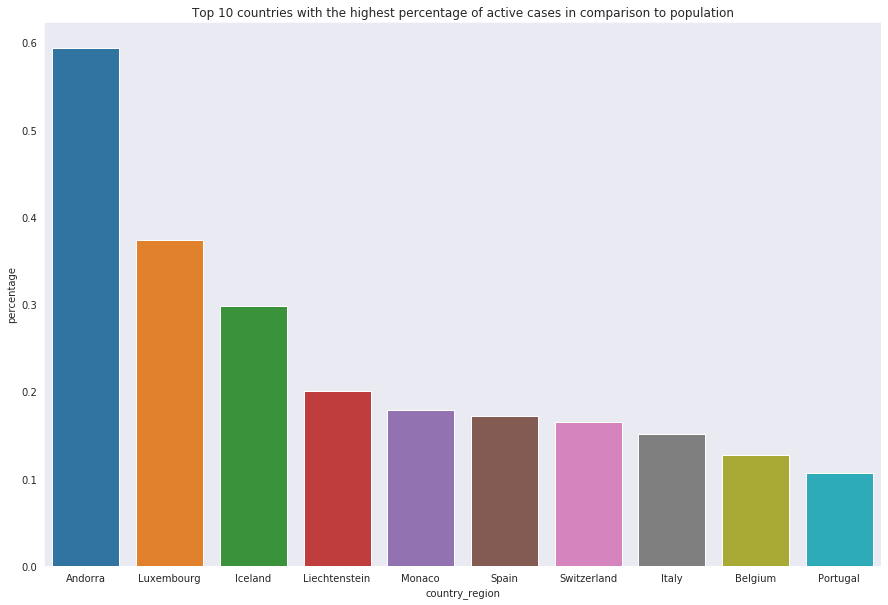

In [11]:
country_data['percentage'] = country_data['active']/country_data['pop2018']*100
plt.clf()
plt.figure(figsize=(15,10))
ax = sns.barplot(x="country_region", y="percentage", data=country_data.sort_values(by='percentage', ascending=False).head(10))
ax.set_title("Top 10 countries with the highest percentage of active cases in comparison to population")
plt.show()

The data is from the 5th of April, so it's before the major boom in the United States. We can observe the highest rate in the smallest countries. However see that in the plot we have 4th and 10th biggest European countries: Spain and Italy according to https://www.worldatlas.com/articles/the-largest-countries-in-europe.html.

Now let's see how the number of active cases compares to the population density.

<Figure size 432x288 with 0 Axes>

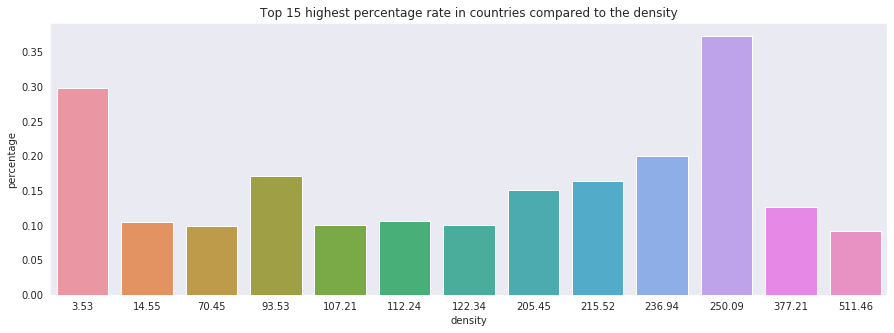

In [12]:
plt.clf()
plt.figure(figsize=(15,5))
ax = sns.barplot(x="density", y="percentage", data=country_data.sort_values(by="percentage", ascending=False).head(15))
ax.set_title("Top 15 highest percentage rate in countries compared to the density")
plt.show()

So we can tell that the higher infection rate is correlated with country density, we can observe more active cases above 0.1% of the population for countries with a density above 93 people per square kilometer. So the bigger the density, the higher probability that rate of infection will be high, of course, the density is calculated as the population over the country area - so in some cases, it's not true as we can see for the first country on the diagram. We can see, however, that in some cases, despite the high density the infection rate is relatively small (the last two bars), this can be caused by various reasons, which should be investigated (I'm counting on fast government reaction, people discipline and the fact that the epidemy may only be starting there).

Now let's see how the number of active cases looks like in countries based on the percentage of people living in urban areas.

<Figure size 432x288 with 0 Axes>

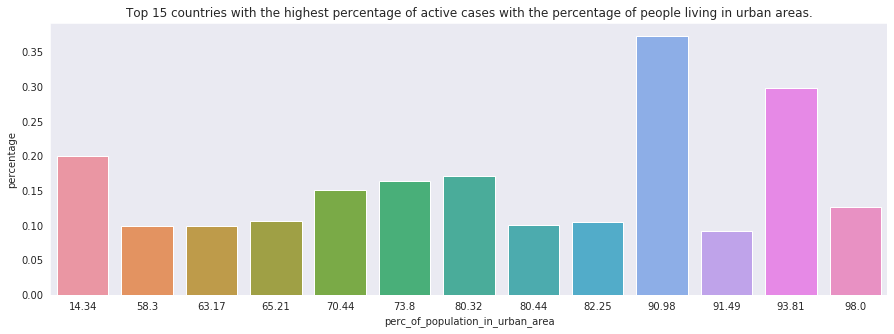

In [13]:
plt.clf()
plt.figure(figsize=(15,5))
ax = sns.barplot(x="perc_of_population_in_urban_area", y="percentage", data=country_data.sort_values(by="percentage", ascending=False).head(15))
ax.set_title("Top 15 countries with the highest percentage of active cases with the percentage of people living in urban areas.")
plt.show()

Based on this diagram we can tell that when more people are living in the urban areas the infection rate is higher, however, I would not put is as ground truth yet, as we don't know here what is the reason why some countries have this rate so low.

## Which US hospitals requires the equipment most?

In this section I would like to see how different states require equipment. Let's gather information about hospitals per state and number of cases per state.

In [14]:
hospitals = pd.read_csv('kaggle/input/uncover/UNCOVER/esri_covid-19/esri_covid-19/definitive-healthcare-usa-hospital-beds.csv')
hospitals['num_licens'] = hospitals['num_licens'].replace("****", 0)
hospitals['num_licens'] = hospitals['num_licens'].astype('int32')
hospitals['num_icu_be'] = hospitals['num_icu_be'].fillna(0)
hospitals['num_icu_be'] = hospitals['num_icu_be'].astype('int32')

covid_us = pd.read_csv('kaggle/input/uncover/UNCOVER/covid_tracking_project/covid-statistics-by-us-states-totals.csv')
covid_us['hospitalized'] = covid_us['hospitalized'].fillna(0)
covid_us['hospitalized'] = covid_us['hospitalized'].astype('int32')

hospitals.head()

,geometry,objectid,hospital_n,hospital_t,hq_address,hq_addre_1,hq_city,hq_state,hq_zip_cod,county_nam,state_name,state_fips,cnty_fips,fips,num_licens,num_staffe,num_icu_be,bed_utiliz,potential
0,POINT (-112.0661569 33.4954978),1,Phoenix VA Health Care System (AKA Carl T Hayd...,VA Hospital,650 E Indian School Rd,NaN,Phoenix,AZ,85012,Maricopa,Arizona,4.0,13.0,4013.0,62,62,0,NaN,0
1,POINT (-110.9658852 32.1812634),2,Southern Arizona VA Health Care System,VA Hospital,3601 S 6th Ave,NaN,Tucson,AZ,85723,Pima,Arizona,4.0,19.0,4019.0,0,****,0,NaN,0
2,POINT (-119.7797421 36.7733235),3,VA Central California Health Care System,VA Hospital,2615 E Clinton Ave,NaN,Fresno,CA,93703,Fresno,California,6.0,19.0,6019.0,0,****,0,NaN,0
3,POINT (-72.9576103 41.2844004),4,VA Connecticut Healthcare System - West Haven ...,VA Hospital,950 Campbell Ave,NaN,West Haven,CT,6516,New Haven,Connecticut,9.0,9.0,9009.0,216,216,0,NaN,0
4,POINT (-75.6065325 39.7402063),5,Wilmington VA Medical Center,VA Hospital,1601 Kirkwood Hwy,NaN,Wilmington,DE,19805,New Castle,Delaware,10.0,3.0,10003.0,0,****,0,NaN,0


### Number of staff compared to number of cases

Let's see how many licensed personnel is available to treat the patients for different states.

In [15]:
def getNumberOfStaff(state_code, hospitals = hospitals):
    h = hospitals.groupby('hq_state')['num_licens'].sum().reset_index()
    return h[h['hq_state'] == state_code]['num_licens'].values[0]

def getNumberOfIcuBeds(state_code, hospitals = hospitals):
    h = hospitals.groupby('hq_state')['num_icu_be'].sum().reset_index()
    return h[h['hq_state'] == state_code]['num_icu_be'].values[0]

In [16]:
df_state = covid_us[['state', 'datemodified', 'hospitalized']].copy()
df_state['active'] = covid_us['positive'].fillna(0) - covid_us['death'].fillna(0)
df_state['active'] = df_state['active'].astype('int32')
df_state['licensed_staff'] = df_state['state'].apply(lambda state: getNumberOfStaff(state))
df_state['icu_beds'] = df_state['state'].apply(lambda state: getNumberOfIcuBeds(state))
df_state['active_per_icu_beds'] = df_state['active']/df_state['icu_beds']
df_state['hospitalized_per_icu_beds'] = (df_state['hospitalized']/df_state['icu_beds'])*100
df_state['active_per_staff'] = df_state['active']/df_state['licensed_staff']
df_state['hospitalized_per_staff'] = df_state['hospitalized']/df_state['licensed_staff']
# df_state.head()

The ICU (Intensive Care Unit) beds are a special type of bed for intensive care patients. They are crucial for treatment the most endangered patients. In the case of the COVID-19, they can support the most critically ill patients providing the respiration.

<Figure size 432x288 with 0 Axes>

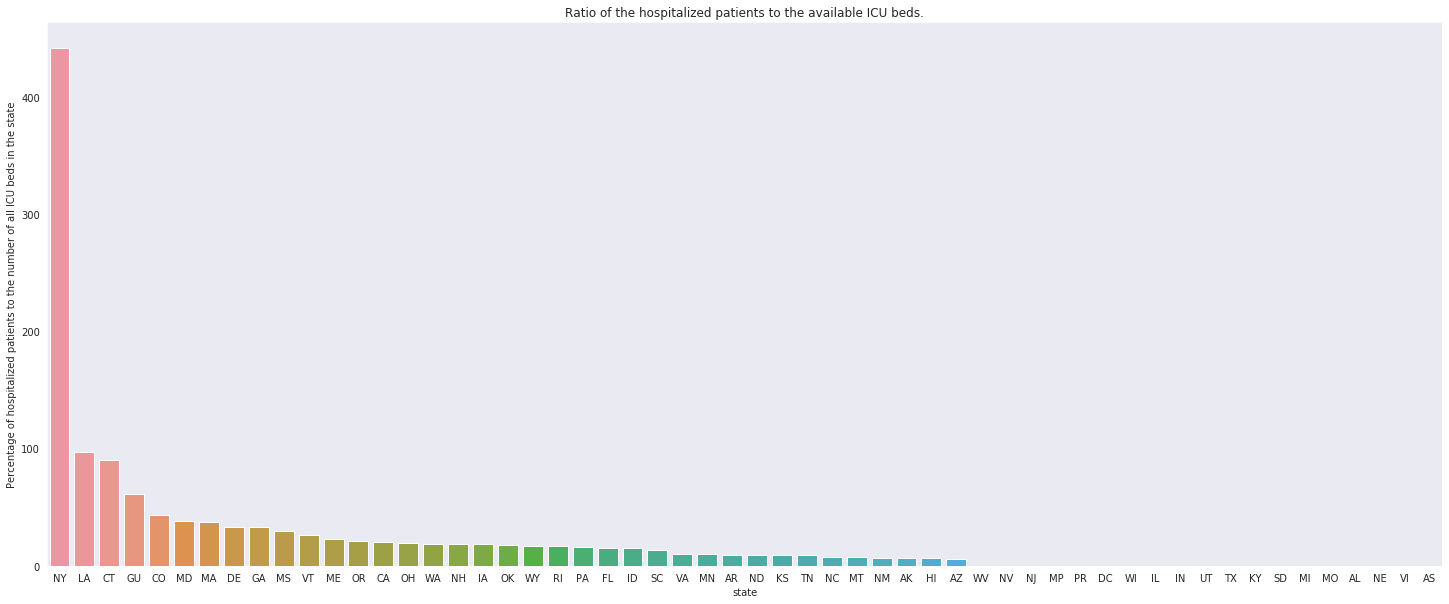

In [17]:
plt.clf()
plt.figure(figsize=(25,10))
ax = sns.barplot(x='state', y='hospitalized_per_icu_beds', data=df_state.sort_values(by='hospitalized_per_icu_beds', ascending=False))
ax.set_title("Ratio of the hospitalized patients to the available ICU beds.")
ax.set_ylabel("Percentage of hospitalized patients to the number of all ICU beds in the state")
plt.show()

So New York has the highest rate of hospitalized people to the availability of ICU beds (over 400%) - due to a big number of hospitalized people the NY hospitals may require additional ICU as the state of some of them may get worse. According to https://newsroom.uw.edu/news/early-study-covid-19-patients-shows-high-mortality-rate the average time spent by COVID-19 patients is 10 days under ICU. We don't know however how many patients will require ICU. But from this diagram, we can tell that at least hospitals in the states: New York (NY), Louisiana(LA) and Connecticut (CT) will require additional ICUs in a short period of time.

Now let's see how the number looks for the staff for hospitalized and non-hospitalized patients.

<Figure size 432x288 with 0 Axes>

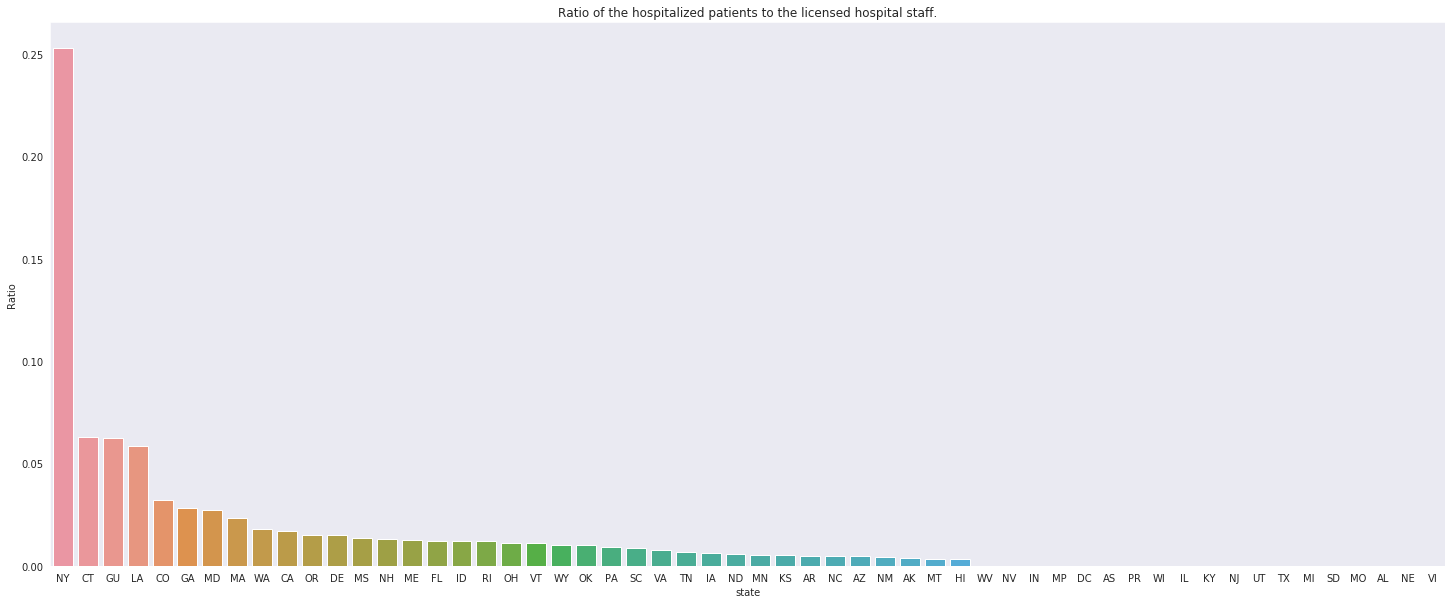

In [18]:
plt.clf()
plt.figure(figsize=(25,10))
ax = sns.barplot(x='state', y='hospitalized_per_staff', data=df_state.sort_values(by='hospitalized_per_staff', ascending=False))
ax.set_title("Ratio of the hospitalized patients to the licensed hospital staff.")
ax.set_ylabel("Ratio")
plt.show()

The NY staff have the highest number of hospitalized patients per one employee - 1 person handles around 4 patients and we here are only the hospitalized patients - the statistics are not showing the information how many of the staff is not working at the hospital directly - e.g. there is no information about the paramedics which are transporting patients between hospitals. If the number of hospitalized patients will increase the hospitals apart of the protective equipment will require staff to perform exchange of tired personnel - the most endangered hospitals are in the New York (NY), Connecticut (CT), Guam (GU) and Louisiana (LA).

Now to see how the situation can change let's see the ratio of the active cases to the staff available.

<Figure size 432x288 with 0 Axes>

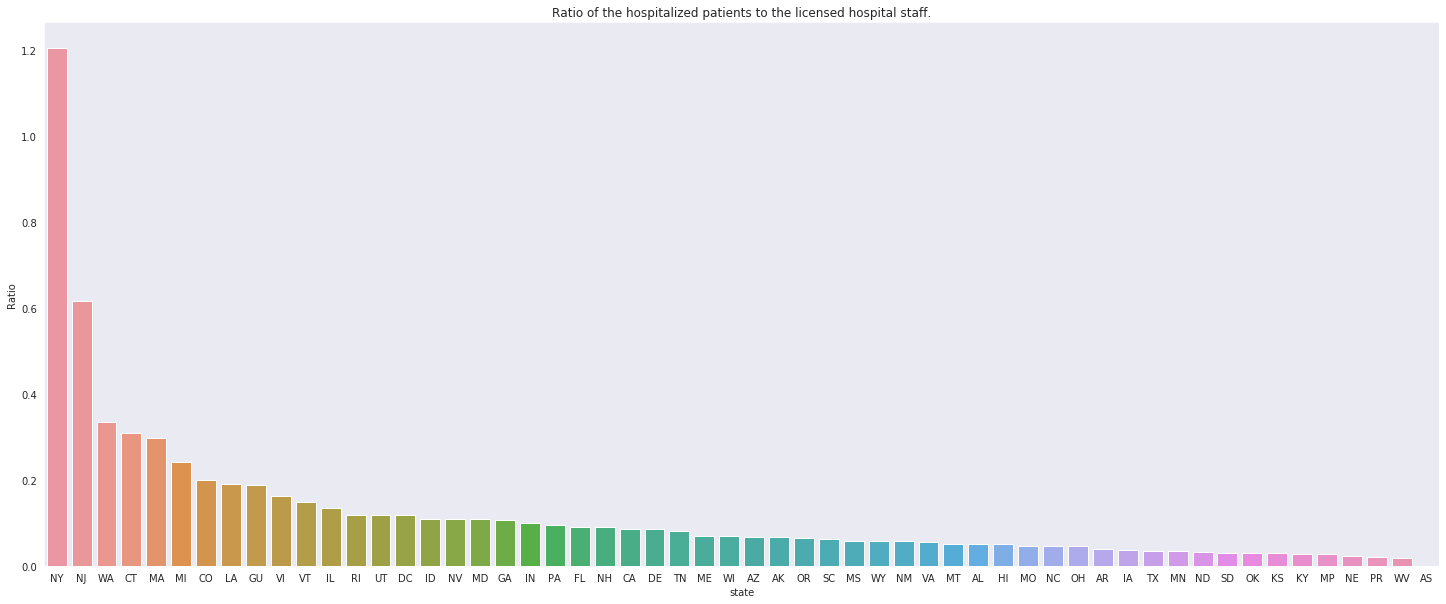

In [19]:
plt.clf()
plt.figure(figsize=(25,10))
ax = sns.barplot(x='state', y='active_per_staff', data=df_state.sort_values(by='active_per_staff', ascending=False))
ax.set_title("Ratio of the hospitalized patients to the licensed hospital staff.")
ax.set_ylabel("Ratio")
plt.show()

Again the situation in New York may change and the staff will require additional support (the number of active cases exceeds the number of the staff available). We need to keep in mind that for in this case not only the hospital staff requires the protective equipment, but also other people e.g. police and people that have to maintain the economy like shopkeepers or even cleaning staff, to maintain their safety and the safety of the environment. In the highest need, there are again New York, but also New Jersey, Washington, Connecticut, and Massachusetts.